In [1]:
!pip -q install jaxlib==0.1.52+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

     |████████████████████████████████| 72.0MB 54kB/s 


In [2]:
!pip -q install jax==0.1.70
!pip -q install neural-tangents==0.2.0
!git clone https://github.com/alexdseo/bayesian-ntk.git
%cd bayesian-ntk
!pip -q install .

     |████████████████████████████████| 378kB 7.8MB/s 
     |████████████████████████████████| 81kB 4.6MB/s 
Cloning into 'bayesian-ntk'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 462 (delta 115), reused 99 (delta 44), pack-reused 271
Receiving objects: 100% (462/462), 2.18 MiB | 6.43 MiB/s, done.
Resolving deltas: 100% (272/272), done.
/content/bayesian-ntk


In [3]:
import jax.numpy as np
from jax import random
from jax import vmap

import functools

from bayesian_ntk.utils import get_toy_data
#from bayesian_ntk.models import homoscedastic_model
from bayesian_ntk.models import bann_model
#from bayesian_ntk.train import train_model
from bayesian_ntk.train_bann import train_model
from bayesian_ntk.predict import Gaussian
from bayesian_ntk import predict, config, train_utils

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt

In [4]:
#@title
##Plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
  
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None): 
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=10)
  if y is not None:
    plt.ylabel(y, fontsize=10)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

##Plotting scheme
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=3, label='train')
  
  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [5]:
model_config = config.get_model_config('bann')
print(model_config)

{'W_std': 1.5, 'b_std': 0.05, 'first_layer_width': 2, 'second_layer_width': 5, 'keep_rate': 0.9, 'subNN_num': 10, 'activation': 'erf'}


In [6]:
_, _, kernel_fn = bann_model(parameterization = 'ntk', **model_config)

In [7]:
key = random.PRNGKey(1892);
data_config = config.get_data_config('default')
train_data, test_data = get_toy_data(key, config.NOISE_SCALE, **data_config)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


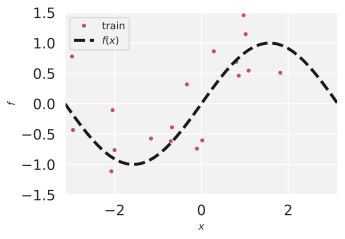

In [8]:
plot_fn(train_data, test_data)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

In [9]:
analytic_ntkgp_moments, analytic_nngp_moments = predict.gp_inference(
    kernel_fn = kernel_fn,
    x_train = train_data.inputs,
    y_train = train_data.targets,
    x_test = test_data.inputs,
    get = ('ntk', 'nngp'),
    diag_reg = 1e-4,
    compute_cov = True
)

predictions = {
    'NTKGP analytic': analytic_ntkgp_moments,
    'NNGP analytic': analytic_nngp_moments
};

/usr/local/lib/python3.7/dist-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.7/dist-packages/neural_tangents/stax.py:2345: UserWarning: `FanIn` layers assume independent inputs which is not verified in the code. Please make sure to have at least one `Dense` / `Conv` / `GlobalSenfAttention` etc. layer in each branch.
  warnings.warn('`FanIn` layers assume independent inputs which is not verified'


In [13]:
train_config = config.get_train_config('bann')
ensemble_key = random.split(key, config.ENSEMBLE_SIZE)
bann_key = random.split(key)
train_baselearner = lambda key, train_method: train_model(key, train_method, train_data, test_data, parameterization = 'standard', **train_config)
train_bann = lambda train_method: vmap(train_baselearner, (0, None))(ensemble_key, train_method)

In [14]:
methods_list = ['BANN']

# this may take a few minutes
for method_idx, method in enumerate(methods_list):
    method_input_str = train_utils.method_input_dct[method]
    print(f"Training base bann method {method_idx+1}/{len(methods_list)}: {method}")
    baselearners_test_pred = train_bann(method_input_str)
    bann_mean = np.mean(baselearners_test_pred, axis = 0).reshape(-1,)
    bann_var = np.var(baselearners_test_pred, axis = 0, ddof = 1).reshape(-1,)
    bann_std = np.sqrt(bann_var + config.NOISE_SCALE ** 2)
    predictions.update(
        {
            method: Gaussian(bann_mean, bann_std)
        }
    )

Training base bann method 1/1: BANN


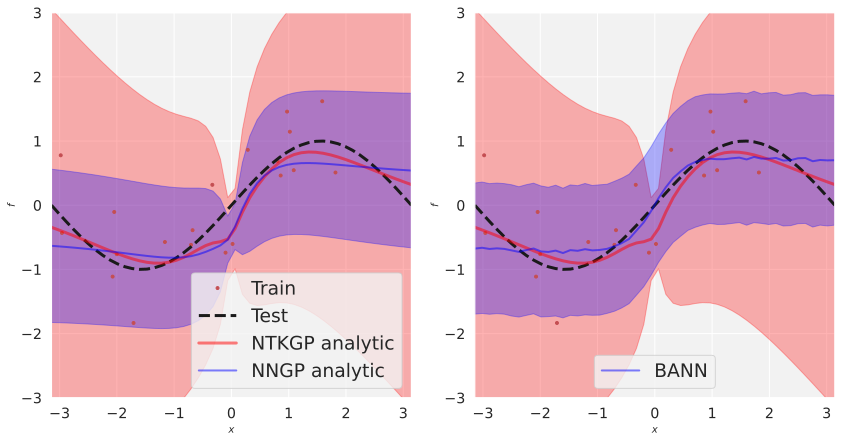

In [15]:
#@title ##### (PLOT CODE)
plot_method_list = ['NNGP analytic'] + methods_list
legend = functools.partial(plt.legend, fontsize=8.5)
for plt_idx in range(1, 3):
    plt.subplot(2, 2, plt_idx)
    plot_fn(train_data, test_data)
    
    ntkgp_moments = predictions['NTKGP analytic']
    ntkgp_means = ntkgp_moments.mean
    ntkgp_stds = ntkgp_moments.standard_deviation
    plt.plot(test_data.inputs, ntkgp_means, 'red', linewidth = 3, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        ntkgp_means - 2 * ntkgp_stds,
        ntkgp_means + 2 * ntkgp_stds,
        color='red',
        alpha = 0.3
    )
    
    method = plot_method_list[plt_idx - 1]
    method_moments = predictions[method]
    method_means = method_moments.mean
    method_stds = method_moments.standard_deviation
    method_plot, = plt.plot(test_data.inputs, method_means, 'blue', linewidth = 2, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        method_means - 2 * method_stds,
        method_means + 2 * method_stds,
        color='blue',
        alpha = 0.3
    )
    if plt_idx == 1:
        legend(['Train', 'Test', 'NTKGP analytic', method], loc = 'lower right', 
            fontsize = "large")
    else:
        legend((method_plot,), [method], loc="lower center", fontsize="large")
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-3, 3])
    format_plot('$x$', '$f$')
finalize_plot((2,2))